In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastai.vision import *
import torch

%matplotlib inline

In [2]:
! tree -d ..

..
├── data
│   ├── axial
│   │   ├── train
│   │   └── valid
│   ├── coronal
│   │   ├── train
│   │   └── valid
│   └── sagittal
│       ├── models
│       ├── train
│       └── valid
└── mrnet-fastai

12 directories


In [3]:
! ls

df_abnl.pkl		 MRNet_fastai_toy.ipynb     train_cases.pkl
LICENSE			 MRNet_pixel-distrib.ipynb  train_pix_distr.pkl
MRNet_EDA.ipynb		 README.md		    Untitled.ipynb
MRNet_fastai_full.ipynb  slice_stats.json


In [4]:
! ls ../data

axial	  train-abnormal.csv  valid-abnormal.csv
coronal   train-acl.csv       valid-acl.csv
sagittal  train-meniscus.csv  valid-meniscus.csv


In [5]:
data_path = Path('../data')
sag_path = data_path/'sagittal'
cor_path = data_path/'coronal'
ax_path = data_path/'axial'

## Substantial class imbalance for the normal/abnormal task

Given this, we'll derive weights for a weighted binary cross entropy loss function.

In [6]:
train_abnl = pd.read_csv(data_path/'train-abnormal.csv', header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})
print(train_abnl.shape)
train_abnl.head()

(1130, 2)


,Case,Abnormal
0,0000,1
1,0001,1
2,0002,1
3,0003,1
4,0004,1


In [7]:
w = train_abnl.Abnormal.sum() / train_abnl.shape[0]
print(w)
weights = Tensor([w, 1-w])
print(weights)

0.8079646017699115
tensor([0.8080, 0.1920])


## Load previously created files

- `df_abnl` -> master `df` for use with Data Block API, also contains # of slices per series
- `slice_stats` -> `dict` stored as `json` with mean and max # of slices per series

In [8]:
df_abnl = pd.read_pickle('df_abnl.pkl')
df_abnl.head()

,Case,Abnormal,is_valid,coronal_slices,sagittal_slices,axial_slices
0,train/0000,1,0,25,27,25
1,train/0001,1,0,22,23,28
2,train/0002,1,0,24,24,24
3,train/0003,1,0,22,21,25
4,train/0004,1,0,30,30,31


In [9]:
with open('slice_stats.json', 'r') as file:
    stats = json.load(file)
    
stats

{'coronal': {'mean': 29.6416, 'max': 57},
 'sagittal': {'mean': 30.3776, 'max': 51},
 'axial': {'mean': 34.2032, 'max': 61}}

In [10]:
max_slc = stats['sagittal']['max']
print(max_slc)

51


## New `ImageList` subclass for loading full stacks from each plane

- `max_slc` set to max # of slices for a given plane...we'll start with sagittal
- "zero slice" padding on either side of each stack for consistent stack size input into model
- new `arr2image` method for converting `np.ndarray` to `Image` class from `fastai.vision`

In [11]:
class MR3DImageList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_slc = 51 # max for sagittal images in train dataset
        self.c = 1
        
    def open(self, fn):
        x = np.load(fn)
        if x.shape[0] < self.max_slc:
            x_pad = np.zeros((self.max_slc, 256, 256))
            mid = x_pad.shape[0] // 2
            up = x.shape[0] // 2
            if x.shape[0] % 2 == 1: x_pad[mid-up:mid+up+1] = x
            else: x_pad[mid-up:mid+up] = x
        else:
            x_pad = x
        return self.arr2image(np.stack([x_pad]*3, axis=1))
    
    @staticmethod
    def arr2image(arr:np.ndarray, div:bool=True, cls:type=Image):
        x = Tensor(arr)
        if div == True: x.div_(255)
        return cls(x)


In [12]:
il = MR3DImageList.from_df(df_abnl, sag_path, suffix='.npy')

In [13]:
il.items[0]

'../data/sagittal/train/0000.npy'

In [14]:
il

MR3DImageList (1250 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal

In [15]:
sd = il.split_from_df(col=2)
sd

ItemLists;

Train: MR3DImageList (1130 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal;

Valid: MR3DImageList (120 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal;

Test: None

In [16]:
ll = sd.label_from_df(cols=1)
ll

LabelLists;

Train: LabelList (1130 items)
x: MR3DImageList
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
y: CategoryList
1,1,1,1,1
Path: ../data/sagittal;

Valid: LabelList (120 items)
x: MR3DImageList
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: ../data/sagittal;

Test: None

In [17]:
# Commenting this out for now, as standard transforms can't be applied to image stacks
# tfms = get_transforms()

In [18]:
bs = 1 # MRNet implementation only supports batch size of 1
data = ll.databunch(bs=bs)

## MRNet implementation

Modified from the original [paper](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002699) to (sort of) work with `fastai`

In [11]:
class MRNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.model = models.alexnet(pretrained=pretrained)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(256, 1)
        
    def forward(self, x):
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        x = self.model.features(x)
        x = self.gap(x).view(x.size(0), -1)
        x = torch.max(x, 0, keepdim=True)[0]
        return self.classifier(x)
    
    def __call__(self, x): return self.forward(x)


In [20]:
def get_model(lr=0.01):
    model = MRNet()
    return model, optim.SGD(model.parameters(), lr=lr)


In [25]:
lr = 0.001
model, opt = get_model(lr)
train_dl = data.train_dl
valid_dl = data.valid_dl

## Weighted binary cross entropy loss

Custom function, subclassed from `nn.Module`

In [12]:
class WtBCELoss(nn.Module):
    def __init__(self, wts):
        super().__init__()
        self.wts = wts.float()
        
    def forward(self, output, target):
        loss = self.wts[0]*(target.float() * torch.log(output).float()) + self.wts[1]*(
                            (1-target).float() * torch.log(1-output).float())
        return torch.neg(torch.mean(loss))

In [23]:
device = torch.device('cuda', 0)
torch.cuda.set_device(device)

wts = weights.cuda()
loss_func = WtBCELoss(wts)

## Custom training loop

Derived from fast.ai course part 2 (2019 edition) to work with MRNet implementation

In [26]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    model.cuda()
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            xb, yb = xb.cuda(), yb.cuda()
            loss = loss_func(model(xb).squeeze(), yb.squeeze().float())
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                xb, yb = xb.cuda(), yb.cuda()
                pred = model(xb)
                tot_loss += loss_func(pred.squeeze(), yb.squeeze().float())
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [27]:
fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(nan, device='cuda:0') tensor(0.2083, device='cuda:0')
1 tensor(nan, device='cuda:0') tensor(0.2083, device='cuda:0')


KeyboardInterrupt: 

## Interim summary

So it's sort of working, but obviously not training very well...

Rather than troubleshoot at this point, I want to see if I can get some other `fastai` functionality up and running to make life a little easier.

So I'm gonna try to load the data into a `cnn_learner` and see where that leads me.

In [35]:
learn = cnn_learner(data, MRNet,
                    opt_func=optim.SGD,
                    loss_func=WtBCELoss(weights),
                    metrics=accuracy)

In [36]:
learn.summary()

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 11, 11], but got 5-dimensional input of size [1, 51, 3, 256, 256] instead

Based on the traceback, it seems there's an issue with how `Learner` handles the call to `MRNet`. It seems it isn't utilizing the custom `forward` function defined above.

So let's try just passing `alexnet` and see what happens.

In [37]:
learn = cnn_learner(data, models.alexnet, opt_func=optim.Adam,
                    loss_func=WtBCELoss(weights),
                    metrics=accuracy)

In [38]:
learn.summary()

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 11, 11], but got 5-dimensional input of size [1, 51, 3, 256, 256] instead

No surprise here that we get the same `RuntimeError`. So now to hack our way through the `fastai` API to figure out where we can squeeze the input to get our shapes to match up.

- The first decent looking breadcrumb is in the Hooks API in the function `params_size()`
- Reviewing the code, `x` is returned from `data.one_batch()`, so this might be a good place to start

In [42]:
x = data.one_batch(ds_type=DatasetType.Train, detach=False, denorm=False)[0]
x.shape

torch.Size([1, 51, 3, 256, 256])

In [46]:
x = data.one_batch(ds_type=DatasetType.Train, detach=False, denorm=False)
print(type(x))
print(len(x))
print(x[1])

<class 'tuple'>
2
tensor([1], device='cuda:0')


Maybe we can overwrite the `one_batch` method via a custom `DataBunch` subclass...?

In [21]:
class MR3DImDataBunch(ImageDataBunch):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def one_batch(self, ds_type:DatasetType=DatasetType.Train, detach:bool=True, denorm:bool=True, cpu:bool=True)->Collection[Tensor]:
        "Get one batch from the data loader of `ds_type`. Optionally `detach` and `denorm`."
        dl = self.dl(ds_type)
        w = self.num_workers
        self.num_workers = 0
        try:     x,y = next(iter(dl))
        finally: self.num_workers = w
        if detach: x,y = to_detach(x,cpu=cpu),to_detach(y,cpu=cpu)
        norm = getattr(self,'norm',False)
        if denorm and norm:
            x = self.denorm(x)
            if norm.keywords.get('do_y',False): y = self.denorm(y, do_x=True)
        x = torch.squeeze(x, dim=0) # fingers crossed, this will do the trick
        return x,y


In order to keep the Data Block API in play, we need to pass our new `DataBunch` subclass to our `MR3DImageList`

In [22]:
class MR3DImageList(ImageList):
    _bunch = MR3DImDataBunch
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_slc = 51
        self.c = 1
        
    def open(self, fn):
        x = np.load(fn)
        if x.shape[0] < self.max_slc:
            x_pad = np.zeros((self.max_slc, 256, 256))
            mid = x_pad.shape[0] // 2
            up = x.shape[0] // 2
            if x.shape[0] % 2 == 1: x_pad[mid-up:mid+up+1] = x
            else: x_pad[mid-up:mid+up] = x
        else:
            x_pad = x
        return self.arr2image(np.stack([x_pad]*3, axis=1))
    
    @staticmethod
    def arr2image(arr:np.ndarray, div:bool=True, cls:type=Image):
        x = Tensor(arr)
        if div == True: x.div_(255)
        return cls(x)


Now, we're ready to try again

In [23]:
il = MR3DImageList.from_df(df_abnl, sag_path, suffix='.npy')

In [24]:
il.items[0]

'../data/sagittal/train/0000.npy'

In [25]:
il

MR3DImageList (1250 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal

In [26]:
sd = il.split_from_df(col=2)
sd

ItemLists;

Train: MR3DImageList (1130 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal;

Valid: MR3DImageList (120 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal;

Test: None

In [27]:
ll = sd.label_from_df(cols=1)
ll

LabelLists;

Train: LabelList (1130 items)
x: MR3DImageList
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
y: CategoryList
1,1,1,1,1
Path: ../data/sagittal;

Valid: LabelList (120 items)
x: MR3DImageList
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: ../data/sagittal;

Test: None

In [28]:
# tfms = get_transforms()

In [29]:
bs = 1
data = ll.databunch(bs=bs)

In [30]:
learn = cnn_learner(data, models.alexnet,
                    opt_func=optim.Adam,
                    loss_func=WtBCELoss(weights),
                    metrics=accuracy)

In [31]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 63, 63]         23,296     False     
______________________________________________________________________
ReLU                 [64, 63, 63]         0          False     
______________________________________________________________________
MaxPool2d            [64, 31, 31]         0          False     
______________________________________________________________________
Conv2d               [192, 31, 31]        307,392    False     
______________________________________________________________________
ReLU                 [192, 31, 31]        0          False     
______________________________________________________________________
MaxPool2d            [192, 15, 15]        0          False     
______________________________________________________________________
Conv2d               [384, 15, 15]        663,936    False     
______________________________________________________________

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 11, 11], but got 5-dimensional input of size [1, 51, 3, 256, 256] instead

Alright...we made some progress, but still aren't quite there.

The next breadcrumb is from the call to `progress_bar` in the `fit` method in `basic_train.py`.
- `xb` and `yb` are returned from `progress_bar`, which is passed the `DataLoader` for the training dataset

Let's explore the possibility of a new `DataLoader` subclass...

In [33]:
data.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f366e4054e0>, device=device(type='cuda'), tfms=[], collate_fn=<function data_collate at 0x7f3676712bf8>)

Not only will we need a new `DataLoader` subclass, but we'll need to explore `DeviceDataLoader` as well.

In [34]:
x = next(iter(data.train_dl))

In [35]:
print(type(x))
print(len(x))

<class 'list'>
2


In [36]:
x[0].shape

torch.Size([1, 51, 3, 256, 256])

In [37]:
class MRDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __iter__(self):
        for i in range(0, len(self.dataset), self.batch_size):
            if self.batch_size == 1:
                x, y = self.dataset[i]
                x = torch.squeeze(x, dim=0)
                yield x, y
            else:
                yield self.dataset[i:i+self.batch_size]


Our new `DataLoader` subclass should work, but now we need a new `DeviceDataLoader` subclass

In [38]:
@dataclass
class MRDeviceDataLoader():
    "Bind a `DataLoader` to a `torch.device`."
    dl: MRDataLoader
    device: torch.device
    tfms: List[Callable]=None
    collate_fn: Callable=data_collate
    def __post_init__(self):
        self.dl.collate_fn=self.collate_fn
        self.tfms = listify(self.tfms)

    def __len__(self)->int: return len(self.dl)
    def __getattr__(self,k:str)->Any: return getattr(self.dl, k)
    def __setstate__(self,data:Any): self.__dict__.update(data)

    @property
    def batch_size(self):   return self.dl.batch_size
    @batch_size.setter
    def batch_size(self,v):
        new_kwargs = {**self.dl.init_kwargs, 'batch_size':v, 'collate_fn':self.collate_fn}
        self.dl = self.dl.__class__(self.dl.dataset, **new_kwargs)
        if hasattr(self.dl.dataset, 'bs'): self.dl.dataset.bs = v

    @property
    def num_workers(self):   return self.dl.num_workers
    @num_workers.setter
    def num_workers(self,v): self.dl.num_workers = v

    def add_tfm(self,tfm:Callable)->None:
        "Add `tfm` to `self.tfms`."
        self.tfms.append(tfm)
    def remove_tfm(self,tfm:Callable)->None:
        "Remove `tfm` from `self.tfms`."
        if tfm in self.tfms: self.tfms.remove(tfm)

    def new(self, **kwargs):
        "Create a new copy of `self` with `kwargs` replacing current values."
        new_kwargs = {**self.dl.init_kwargs, **kwargs}
        return MRDeviceDataLoader(self.dl.__class__(self.dl.dataset, **new_kwargs), self.device, self.tfms,
                                self.collate_fn)

    def proc_batch(self,b:Tensor)->Tensor:
        "Process batch `b` of `TensorImage`."
        b = to_device(b, self.device)
        for f in listify(self.tfms): b = f(b)
        return b.squeeze()

    def __iter__(self):
        "Process and returns items from `DataLoader`."
        for b in self.dl: yield self.proc_batch(b)

    @classmethod
    def create(cls, dataset:Dataset, bs:int=64, shuffle:bool=False, device:torch.device=defaults.device,
               tfms:Collection[Callable]=tfms, num_workers:int=defaults.cpus, collate_fn:Callable=data_collate, **kwargs:Any):
        "Create MRDeviceDataLoader from `dataset` with `bs` and `shuffle`: process using `num_workers`."
        return cls(MRDataLoader(dataset, batch_size=bs, shuffle=shuffle, num_workers=num_workers, **kwargs),
                   device=device, tfms=tfms, collate_fn=collate_fn)


We also need to modify our `MR3DImDataBunch` class to ensure the proper DataLoader is utilized.

In [39]:
class MR3DImDataBunch(ImageDataBunch):
    def __init__(self, train_dl:DataLoader, valid_dl:DataLoader, fix_dl:DataLoader=None, test_dl:Optional[DataLoader]=None,
                 device:torch.device=None, dl_tfms:Optional[Collection[Callable]]=None, path:PathOrStr='.',
                 collate_fn:Callable=data_collate, no_check:bool=False):
        self.dl_tfms = listify(dl_tfms)
        self.device = defaults.device if device is None else device
        assert not isinstance(train_dl,DeviceDataLoader)
        def _create_dl(dl, **kwargs):
            if dl is None: return None
            return MRDeviceDataLoader(dl, self.device, self.dl_tfms, collate_fn, **kwargs)
        self.train_dl,self.valid_dl,self.fix_dl,self.test_dl = map(_create_dl, [train_dl,valid_dl,fix_dl,test_dl])
        if fix_dl is None: self.fix_dl = self.train_dl.new(shuffle=False, drop_last=False)
        self.single_dl = _create_dl(MRDataLoader(valid_dl.dataset, batch_size=1, num_workers=0))
        self.path = Path(path)
        if not no_check: self.sanity_check()
    
    @classmethod
    def create(cls, train_ds:Dataset, valid_ds:Dataset, test_ds:Optional[Dataset]=None, path:PathOrStr='.', bs:int=64,
               val_bs:int=None, num_workers:int=defaults.cpus, dl_tfms:Optional[Collection[Callable]]=None,
               device:torch.device=None, collate_fn:Callable=data_collate, no_check:bool=False, **dl_kwargs)->'DataBunch':
        "Create a `DataBunch` from `train_ds`, `valid_ds` and maybe `test_ds` with a batch size of `bs`. Passes `**dl_kwargs` to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        dls = [MRDataLoader(d, b, shuffle=s, drop_last=s, num_workers=num_workers, **dl_kwargs) for d,b,s in
               zip(datasets, (bs,val_bs,val_bs,val_bs), (True,False,False,False)) if d is not None]
        return cls(*dls, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

    
    def one_batch(self, ds_type:DatasetType=DatasetType.Train, detach:bool=True, denorm:bool=True, cpu:bool=True)->Collection[Tensor]:
        "Get one batch from the data loader of `ds_type`. Optionally `detach` and `denorm`."
        dl = self.dl(ds_type)
        w = self.num_workers
        self.num_workers = 0
        try:     x,y = next(iter(dl))
        finally: self.num_workers = w
        if detach: x,y = to_detach(x,cpu=cpu),to_detach(y,cpu=cpu)
        norm = getattr(self,'norm',False)
        if denorm and norm:
            x = self.denorm(x)
            if norm.keywords.get('do_y',False): y = self.denorm(y, do_x=True)
        x = torch.squeeze(x, dim=0) # fingers crossed, this will do the trick
        return x,y


No changes to this class this time...

In [51]:
class MR3DImageList(ImageList):
    _bunch = MR3DImDataBunch
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_slc = 51
        self.c = 1
        
    def open(self, fn):
        x = np.load(fn)
        if x.shape[0] < self.max_slc:
            x_pad = np.zeros((self.max_slc, 256, 256))
            mid = x_pad.shape[0] // 2
            up = x.shape[0] // 2
            if x.shape[0] % 2 == 1: x_pad[mid-up:mid+up+1] = x
            else: x_pad[mid-up:mid+up] = x
        else:
            x_pad = x
        return self.arr2image(np.stack([x_pad]*3, axis=1))
    
    @staticmethod
    def arr2image(arr:np.ndarray, div:bool=True, cls:type=Image):
        x = Tensor(arr)
        if div == True: x.div_(255)
        return cls(x)


Once more, we're ready to try again...

In [52]:
il = MR3DImageList.from_df(df_abnl, sag_path, suffix='.npy')

In [53]:
il.items[0]

'../data/sagittal/train/0000.npy'

In [54]:
il

MR3DImageList (1250 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal

In [55]:
sd = il.split_from_df(col=2)
sd

ItemLists;

Train: MR3DImageList (1130 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal;

Valid: MR3DImageList (120 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal;

Test: None

In [56]:
ll = sd.label_from_df(cols=1)
ll

LabelLists;

Train: LabelList (1130 items)
x: MR3DImageList
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
y: CategoryList
1,1,1,1,1
Path: ../data/sagittal;

Valid: LabelList (120 items)
x: MR3DImageList
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: ../data/sagittal;

Test: None

In [57]:
# tfms = get_transforms()

In [58]:
bs = 1
data = ll.databunch(bs=bs)

In [59]:
learn = cnn_learner(data, models.alexnet,
                    opt_func=optim.Adam,
                    loss_func=WtBCELoss(weights),
                    metrics=accuracy)

In [60]:
learn.summary()

TypeError: squeeze(): argument 'input' (position 1) must be Tensor, not Image

Well, crap. It looks like our change to `DataLoader` wasn't quite right. But it also shows that if you *successfully* change the `DataLoader`, you don't need to overwrite `one_batch`.

Going back to the drawing board... it actually looks like we might be able to write a Callback (see line 99 below) that does what we need it to do, rather than creating a new `DataLoader`.

```
~/miniconda3/envs/fastai/lib/python3.7/site-packages/fastai/basic_train.py in fit(epochs, learn, callbacks, metrics)
     98             for xb,yb in progress_bar(learn.data.train_dl, parent=pbar):
     99                 **xb, yb = cb_handler.on_batch_begin(xb, yb)**
--> 100                 loss = loss_batch(learn.model, xb, yb, learn.loss_func, learn.opt, cb_handler)
    101                 if cb_handler.on_batch_end(loss): break
    102 
```
If the Callback can squeeze the dims of `xb`, then we might be in business. Doing this still requires that we keep our modification to `one_batch`.

But first, let's step back on our `DataBunch` subclass.

In [13]:
class MR3DImDataBunch(ImageDataBunch):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def one_batch(self, ds_type:DatasetType=DatasetType.Train, detach:bool=True, denorm:bool=True, cpu:bool=True)->Collection[Tensor]:
        "Get one batch from the data loader of `ds_type`. Optionally `detach` and `denorm`."
        dl = self.dl(ds_type)
        w = self.num_workers
        self.num_workers = 0
        try:     x,y = next(iter(dl))
        finally: self.num_workers = w
        if detach: x,y = to_detach(x,cpu=cpu),to_detach(y,cpu=cpu)
        norm = getattr(self,'norm',False)
        if denorm and norm:
            x = self.denorm(x)
            if norm.keywords.get('do_y',False): y = self.denorm(y, do_x=True)
        x = torch.squeeze(x, dim=0) # fingers crossed, this will do the trick
        return x,y


In [14]:
class MR3DImageList(ImageList):
    _bunch = MR3DImDataBunch
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_slc = 51
        self.c = 1
        
    def open(self, fn):
        x = np.load(fn)
        if x.shape[0] < self.max_slc:
            x_pad = np.zeros((self.max_slc, 256, 256))
            mid = x_pad.shape[0] // 2
            up = x.shape[0] // 2
            if x.shape[0] % 2 == 1: x_pad[mid-up:mid+up+1] = x
            else: x_pad[mid-up:mid+up] = x
        else:
            x_pad = x
        return self.arr2image(np.stack([x_pad]*3, axis=1))
    
    @staticmethod
    def arr2image(arr:np.ndarray, div:bool=True, cls:type=Image):
        x = Tensor(arr)
        if div == True: x.div_(255)
        return cls(x)


Now, to write our Callback...

In [15]:
class MRNetCallback(Callback):
    def on_batch_begin(self, last_input, **kwargs):
        x = torch.squeeze(last_input, dim=0)
        return dict(last_input=x)


And we're ready to try again...again...

In [16]:
il = MR3DImageList.from_df(df_abnl, sag_path, suffix='.npy')

In [17]:
il.items[0]

'../data/sagittal/train/0000.npy'

In [18]:
il

MR3DImageList (1250 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal

In [19]:
sd = il.split_from_df(col=2)
sd

ItemLists;

Train: MR3DImageList (1130 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal;

Valid: MR3DImageList (120 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal;

Test: None

In [20]:
ll = sd.label_from_df(cols=1)
ll

LabelLists;

Train: LabelList (1130 items)
x: MR3DImageList
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
y: CategoryList
1,1,1,1,1
Path: ../data/sagittal;

Valid: LabelList (120 items)
x: MR3DImageList
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: ../data/sagittal;

Test: None

In [21]:
# tfms = get_transforms()

In [22]:
bs = 1
data = ll.databunch(bs=bs)

In [22]:
learn = cnn_learner(data, models.alexnet,
                    opt_func=optim.Adam,
                    loss_func=WtBCELoss(weights),
                    callbacks=MRNetCallback(),
                    metrics=accuracy)

In [23]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 63, 63]         23,296     False     
______________________________________________________________________
ReLU                 [64, 63, 63]         0          False     
______________________________________________________________________
MaxPool2d            [64, 31, 31]         0          False     
______________________________________________________________________
Conv2d               [192, 31, 31]        307,392    False     
______________________________________________________________________
ReLU                 [192, 31, 31]        0          False     
______________________________________________________________________
MaxPool2d            [192, 15, 15]        0          False     
______________________________________________________________________
Conv2d               [384, 15, 15]        663,936    False     
______________________________________________________________

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


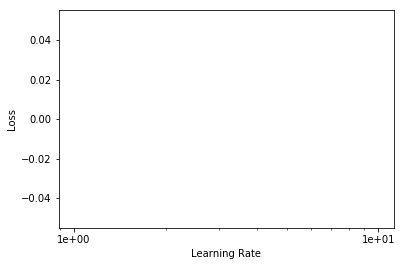

In [25]:
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

Loss is NaN on each iteration... Let's figure out why.

In [27]:
class WtBCELoss(nn.Module):
    def __init__(self, wts):
        super().__init__()
        self.wts = wts.float()
        
    def forward(self, output, target):
        loss = self.wts[0]*(target.float() * torch.log(output).float()) + self.wts[1]*(
                            (1-target).float() * torch.log(1-output).float())
        return torch.neg(torch.mean(loss))

In [28]:
loss_func = WtBCELoss(weights)

In [35]:
output = Tensor([0.689])
target = Tensor([0.])

In [36]:
loss_func.forward(output, target)

tensor(0.2243)

In [45]:
learn = cnn_learner(data, models.alexnet,
                    opt_func=optim.Adam,
                    loss_func=nn.BCELoss(),
                    callbacks=MRNetCallback(),
                    metrics=accuracy)

In [46]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time


ValueError: Target and input must have the same number of elements. target nelement (1) != input nelement (102)

Seems like the custom `forward` function from MRNet might be able to help us with the `input`-`target` mismatch.

In [47]:
learn = cnn_learner(data, MRNet(),
                    opt_func=optim.Adam,
                    loss_func=nn.BCELoss(),
                    callbacks=MRNetCallback(),
                    metrics=accuracy)

TypeError: squeeze(): argument 'input' (position 1) must be Tensor, not bool

Probably need to rewrite `cnn_learner` to get the custom model implementation to work.

In [23]:
def mrnet_learner(data:DataBunch, model:Callable=MRNet(), pretrained:bool=True, init=nn.init.kaiming_normal_,
                  **kwargs:Any)->Learner:
    learn = Learner(data, model, **kwargs)
    learn.split(split_on)
    if pretrained: learn.freeze()
    if init: apply_init(model[1], init)
    return learn


In [24]:
learn = mrnet_learner(data, MRNet(), opt_func=optim.Adam, loss_func=WtBCELoss(weights),
                      callbacks=MRNetCallback(), metrics=accuracy)

AssertionError: 

In [25]:
model = MRNet()

In [30]:
model.model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

Probably need a custom `Learner` too...in order to enable freezing, but will experiment further in part 2.